In [1]:
import pandas as pd
import numpy as np
import datetime
import sklearn
import scikit_posthocs as sp
import statsmodels.formula.api as sfa
import statsmodels.api as sa
import os
from pathlib import Path
import seaborn as sns
import scipy
import neurokit2 as nk

import tqdm 


from collections import Counter
import matplotlib.pyplot as plt

In [2]:
lstPIds = []
path = "./Data/"
for filename in os.listdir(path):
    if filename.endswith(".csv"): 
        lstPIds.append(int(filename.split("-")[0].replace("ID", "")))
    else:
        continue
lstPIds = list(set(lstPIds))
print(lstPIds)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [3]:
pid=1 #701 has first block 7 and then block 6

In [74]:
df_state = pd.read_csv(path+f'ID{pid}-state.csv')
df_state.sort_values(by='Time', inplace=True)
df_adapt = pd.read_csv(path+f'ID{pid}-adaptation.csv')
df_adapt.sort_values(by='Time', inplace=True)
df_adapt = df_adapt[['Time', 'CurrentCount', 'Status']]
df_eda = pd.read_csv(path+f'ID{pid}-EDA.csv')


edaFs = 250  # Sampling frequency

df_eda.Value = (df_eda.Value / 1000) / 25
df_eda["TimeNorm"] = df_eda.Time-df_eda.Time.iloc[0]
df_eda["EDAClean"] =  nk.eda_clean(df_eda["Value"], sampling_rate=edaFs) #scipy.signal.medfilt(dfEDA.Value, edaFs +1)
#sos = scipy.signal.butter(1, 0.01, btype='lowpass', analog=False, output='sos', fs=edaFs)
#dfEDA["EDAButter"] = scipy.signal.sosfilt(sos, dfEDA["EDAMedian"])
#signal, info=nk.eda_process(nk.standardize(dfEDA.EDAClean, sampling_rate=edaFs), sampling_rate=edaFs)
#signal2, info = nk.eda_sympathetic(dfEDA.EDAClean, sampling_rate=edaFs, frequency_band=[0.045, 0.25], method='posada', show=False)
signal, info=nk.eda_process(df_eda.EDAClean, sampling_rate=edaFs)
df_eda["EDARaw"] = signal.EDA_Raw
df_eda["EDATonic"] = signal.EDA_Tonic



df_eda.sort_values(by='Time', inplace=True)
df_eda = df_eda[['Time', 'EDATonic']]
t_min, t_max = min(df_state.Time.min(), df_adapt.Time.min()), max(df_state.Time.max(), df_adapt.Time.max())
count_min, count_max = df_adapt.CurrentCount.min(), df_adapt.CurrentCount.max()

def get_time(status):
    start = df_state[(df_state.State == 'start') & (df_state.BlockNumber == status)].Time.values[0]
    start_index = df_state[(df_state.State == 'start') & (df_state.BlockNumber == status)].index.values[0]
    end = df_state.loc[start_index+1, 'Time']
    return start, end

def get_state_time(state_1, state_2):
    start1, end1 = get_time(state_1)
    start2, end2 = get_time(state_2)
    return min(start1, start2), max(end1, end2)

def get_state_time_between(state_1, state_2):
    start1, end1 = get_time(state_1)
    start2, end2 = get_time(state_2)
    return min(end1, end2), max(start1, start2)
    

def unix_to_datetime(unix_time):
    return pd.to_datetime(unix_time, unit='s')

def get_df_adapt(t_start, t_end):
    df_state = df_adapt[(df_adapt.Time >= t_start) & (df_adapt.Time <= t_end)]
    df_state['Time'] = (df_state['Time'] - t_min) / (t_max - t_min)
    return df_state

def get_df_eda(t_start, t_end):
    df_state = df_eda[(df_eda.Time >= t_start) & (df_eda.Time <= t_end)]
    df_state['Time'] = (df_state['Time'] - t_min) / (t_max - t_min)
    return df_state

In [75]:
t_start, t_end = get_state_time(6, 7)
state_end, state_start = get_state_time_between(6, 7)

df_adapt = get_df_adapt(t_start, t_end)
df_adapt.CurrentCount = (df_adapt.CurrentCount - count_min)/ (count_max - count_min)

df_eda["EDAClean"] =  nk.eda_clean(df_eda["Value"], sampling_rate=250) #scipy.signal.medfilt(dfEDA.Value, edaFs +1)
signal, info=nk.eda_process(df_eda.EDAClean, sampling_rate=250)

df_eda["EDARaw"] = signal.EDA_Raw
df_eda["EDATonic"] = signal.EDA_Tonic
df_eda["EDAPhasic"] = signal.EDA_Phasic
df_eda = get_df_eda(t_start, t_end)
eda_min, eda_max = df_eda.EDATonic.min(), df_eda.EDATonic.max()
df_eda.EDATonic = (df_eda.EDATonic - df_eda.EDATonic.min())/ (df_eda.EDATonic.max() - df_eda.EDATonic.min())
#df_eda_sampled = df_eda.sample(2500).sort_values(by='Time').sort_index()

KeyError: 'Value'

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()

sns.lineplot(df_adapt.Time, df_adapt.CurrentCount, drawstyle='steps-pre', ax=ax, color='red')
sns.lineplot(ax=ax2, x='Time', y='EDATonic', data=df_eda_sampled, color='blue')
ax.axvspan((state_end-t_min)/(t_max-t_min), (state_start - t_min)/(t_max - t_min), color='black', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_xlim(0, 1)

t_end_second = (unix_to_datetime(t_end) - unix_to_datetime(t_start)).seconds
ax.set_xlabel('Time (s)')
ax.set_xticklabels(f'{x:.0f}' for x in (ax.get_xticks() * t_end_second))
ax.set_yticklabels(f'{x:.0f}' for x in (ax.get_yticks() * (count_max - count_min) + count_min))
ax2.set_yticklabels(f'{x:.0f}' for x in (ax2.get_yticks() * (eda_max - eda_min) + eda_min))
# ax.yaxis.tick_left()

# ax.yaxis.tick_left(f'{x:.0f}' for x in (ax.yaxis.tick_left() * (count_max - count_min) + count_min))
# ax.yaxis.tick_right(f'{x:.0f}' for x in (ax.yaxis.tick_right() * (eda_max - eda_min) + eda_min))

# Plot slope

In [16]:
pid = 10

In [17]:
df_state = pd.read_csv(path+f'ID{pid}-state.csv')
df_state.sort_values(by='Time', inplace=True)
df_adapt = pd.read_csv(path+f'ID{pid}-adaptation.csv')
df_adapt.sort_values(by='Time', inplace=True)
#df_adapt = df_adapt[['Time', 'CurrentCount', 'Status',]]
df_eda = pd.read_csv(path+f'ID{pid}-EDA.csv')

In [18]:
df_eda
df_eda["EDAClean"] =  nk.eda_clean(df_eda["Value"], sampling_rate=250) #scipy.signal.medfilt(dfEDA.Value, edaFs +1)
signal, info=nk.eda_process(df_eda.EDAClean, sampling_rate=250)

df_eda["EDARaw"] = signal.EDA_Raw
df_eda["EDATonic"] = signal.EDA_Tonic
df_eda["EDAPhasic"] = signal.EDA_Phasic

In [19]:
df_adapt.Time.min()

1662390045.91704

In [20]:
df_eda.Time = df_eda.Time -df_adapt.Time.min()
df_adapt.Time =df_adapt.Time - df_adapt.Time.min()

In [21]:
df_adapt["Adapt"] = df_adapt["SlopeT2"] - df_adapt["SlopeT1"]#difference

In [22]:
df_adapt["Ratio"] = df_adapt["SlopeT2"] / df_adapt["SlopeT1"] #ratio

C:\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


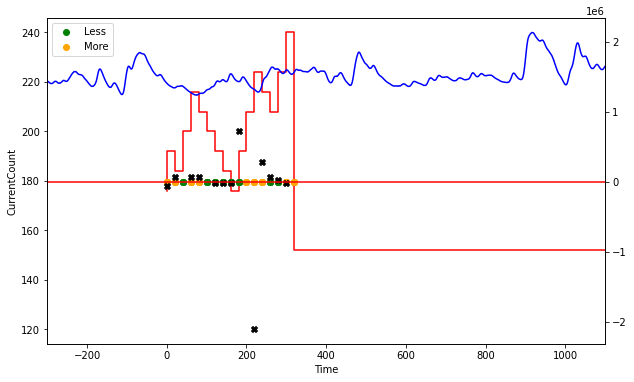

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()
scale = 10

slopeThreshold  = 0.01
sns.lineplot(df_adapt.Time, df_adapt.CurrentCount, drawstyle='steps-pre', ax=ax, color='red')

ax2.plot(df_eda.Time, df_eda.EDATonic * scale,  color='blue')
#sns.lineplot(df_adapt.Time, df_adapt["Slope-t1"]*30, drawstyle='steps-pre', ax=ax2,color='yellow')
#sns.lineplot(df_adapt.Time, df_adapt["Slope-t2"]*30, drawstyle='steps-pre', ax=ax2,color='green')

dfX =  df_adapt[(df_adapt.Adapt > 0) & (df_adapt.Status == 6)]
ax2.scatter(dfX.Time, dfX.Adapt* scale, color='green', label="Less")
ax2.scatter(dfX.Time, (dfX.Adapt - slopeThreshold) * scale, marker ="X",  color='green')
dfY = dfX[(dfX.Ratio < -1) | (dfX.Ratio > 1)]
ax2.scatter(dfY.Time, dfY.Ratio * 10000, marker ="X",  color='black')#ratio smaller or bigger than 1
dfX =  df_adapt[(df_adapt.Adapt < 0) & (df_adapt.Status == 6)]
ax2.scatter(dfX.Time, dfX.Adapt* scale, color='orange', label="More")
ax2.scatter(dfX.Time, (dfX.Adapt + slopeThreshold) * scale, marker ="X",  color='orange')
dfY = dfX[(dfX.Ratio < -1) | (dfX.Ratio > 1)]
ax2.scatter(dfY.Time, dfY.Ratio * 10000, marker ="X",  color='black')
#ax2.scatter(dfX.Time, (dfX.SlopeT2 /dfX.SlopeT1) * scale * 1000000000, marker ="X",  color='orange')

dfX =  df_adapt[(df_adapt.Adapt < 0) & (df_adapt.Status == 7)]
ax2.scatter(dfX.Time, dfX.Adapt* scale, color='green', label="Less 7")
ax2.scatter(dfX.Time, (dfX.Adapt + slopeThreshold) * scale, marker ="X",  color='green')
dfY = dfX[(dfX.Ratio < -1) | (dfX.Ratio > 1)]
ax2.scatter(dfY.Time, dfY.Ratio * 10000, marker ="s",  color='black')

dfX =  df_adapt[(df_adapt.Adapt > 0) & (df_adapt.Status == 7)]
ax2.scatter(dfX.Time, dfX.Adapt * scale, color='orange', label="More 7")
ax2.scatter(dfX.Time, (dfX.Adapt - slopeThreshold) * scale, marker ="X",  color='orange')
dfY = dfX[(dfX.Ratio < .5) | (dfX.Ratio > 1.5)]
ax2.scatter(dfY.Time, dfY.Ratio * 10000, marker ="X",  color='black')

#ax.axvspan((state_end-t_min)/(t_max-t_min), (state_start - t_min)/(t_max - t_min), color='black', alpha=0.5)
#ax.set_ylim(0, 1)
#ax.set_xlim(0, 1)
#ax2.set_ylim(0, 1)
#ax2.set_xlim(0, 1)
#x2.hlines(0.002 * scale, xmin=-400, xmax=1100)
ax2.hlines(0, xmin=-400, xmax=1100, color="r")
#t_end_second = (unix_to_datetime(t_end) - unix_to_datetime(t_start)).seconds
#ax.set_xlabel('Time (s)')
#ax.set_xticklabels(f'{x:.0f}' for x in (ax.get_xticks() * t_end_second))
#ax.set_yticklabels(f'{x:.0f}' for x in (ax.get_yticks() * (count_max - count_min) + count_min))
#ax2.set_yticklabels(f'{x:.0f}' for x in (ax2.get_yticks() * (eda_max - eda_min) + eda_min))
# ax.yaxis.tick_left()
plt.xlim(-300, 1100)
plt.legend()

In [24]:
df_adapt.Adapt #.001

0    -0.016114
1    -0.018852
2     0.000331
3    -0.006957
4    -0.012276
5     0.011988
6     0.024004
7     0.023815
8     0.006758
9     0.003916
10   -0.004499
11   -0.019890
12   -0.013086
13    0.033433
14    0.013652
15   -0.016533
16   -0.005536
17   -0.025284
18   -0.004816
19   -0.001134
20   -0.005525
21   -0.003568
22    0.005110
23    0.014046
24    0.005854
25    0.021389
26    0.002377
27    0.001763
28    0.034067
29   -0.004914
30   -0.017843
31   -0.010449
32    0.004510
33    0.011759
Name: Adapt, dtype: float64

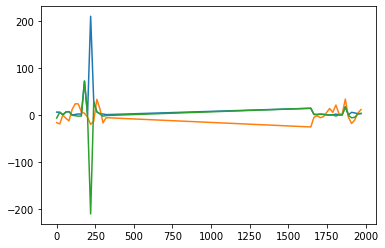

In [25]:
plt.plot(df_adapt.Time, (df_adapt.SlopeT2.abs() /df_adapt.SlopeT1.abs()))
plt.plot(df_adapt.Time, df_adapt.Adapt*1000)
plt.plot(df_adapt.Time, (df_adapt.SlopeT2 /df_adapt.SlopeT1))

In [26]:
print(dfX =  df_adapt[(df_adapt.Adapt < 0) & (df_adapt.Status == 6)])

TypeError: 'dfX' is an invalid keyword argument for print()

In [27]:
df_adapt

,Time,Direction,CurrentCount,SlopeT1,SlopeT2,Status,Adapt,Ratio
0,0.00000,more,176,0.002204,-0.013910,6,-0.016114,-6.309832
1,20.02845,more,192,-0.003739,-0.022591,6,-0.018852,6.041718
2,40.03379,less,184,-0.001112,-0.000781,6,0.000331,0.701998
3,59.99197,more,200,-0.001244,-0.008200,6,-0.006957,6.592886
4,80.00596,more,216,-0.001936,-0.014212,6,-0.012276,7.340504
5,100.03436,less,208,-0.008405,0.003583,6,0.011988,-0.426344
6,120.01733,less,200,-0.010671,0.013333,6,0.024004,-1.249485
7,140.02637,less,192,-0.007099,0.016716,6,0.023815,-2.354764
8,159.99168,less,184,-0.002242,0.004515,6,0.006758,-2.013551
9,180.00237,less,176,0.000055,0.003971,6,0.003916,72.399205
